Connect Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install peptides

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 2.4 MB/s eta 0:00:00


Import data

In [4]:
import pandas as pd
import peptides
mb_raw_data = pd.read_csv('/content/drive/MyDrive/mann_bruker.txt', sep='\t')

Enable GPU

In [5]:
import tensorflow as tf

# Enable GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Rest of your code


SystemError: ignored

Preprocess data

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Keep only necessary columns
mb_clean_frame = mb_raw_data[['Sequence', 'm/z', 'CCS','Mass','Charge','Length']]

# Perform z-score transformation
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

# Save the mean and std for later use
ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

# randomize data set
mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

# Calculate VHSE8 descriptors for each sequence
vhse8_sequences = mb_clean_frame['Sequence'].apply(lambda x: peptides.Peptide(x).vhse_scales())

# Convert the VHSE8 sequences into a DataFrame
vhse8_sequences_df = pd.DataFrame(vhse8_sequences.tolist(), columns=[f'vhse{i}' for i in range(1, 9)])

# Split the data into input (m/z) and output (CCS) variables
X = pd.concat([mb_clean_frame[['Mass', 'Charge', 'Length']], vhse8_sequences_df], axis=1)
y = mb_clean_frame['CCS_z']



<ipython-input-7-d729c58190ea>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])


Train Model

Epoch 1/100
11020/11020 [==============================] - 30s 3ms/step - loss: 0.4180 - val_loss: 0.2318
Epoch 2/100
11020/11020 [==============================] - 29s 3ms/step - loss: 0.1122 - val_loss: 0.0236
Epoch 3/100
11020/11020 [==============================] - 37s 3ms/step - loss: 0.0602 - val_loss: 0.0739
Epoch 4/100
11020/11020 [==============================] - 28s 3ms/step - loss: 0.0347 - val_loss: 0.0147
Epoch 5/100
11020/11020 [==============================] - 28s 3ms/step - loss: 0.0211 - val_loss: 0.1455
Epoch 6/100
11020/11020 [==============================] - 29s 3ms/step - loss: 0.0134 - val_loss: 0.0146
Epoch 7/100
11020/11020 [==============================] - 30s 3ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 8/100
11020/11020 [==============================] - 29s 3ms/step - loss: 0.0119 - val_loss: 0.0105
Epoch 9/100
11020/11020 [==============================] - 30s 3ms/step - loss: 0.0117 - val_loss: 0.0275
Epoch 10/100
11020/11020 [====================

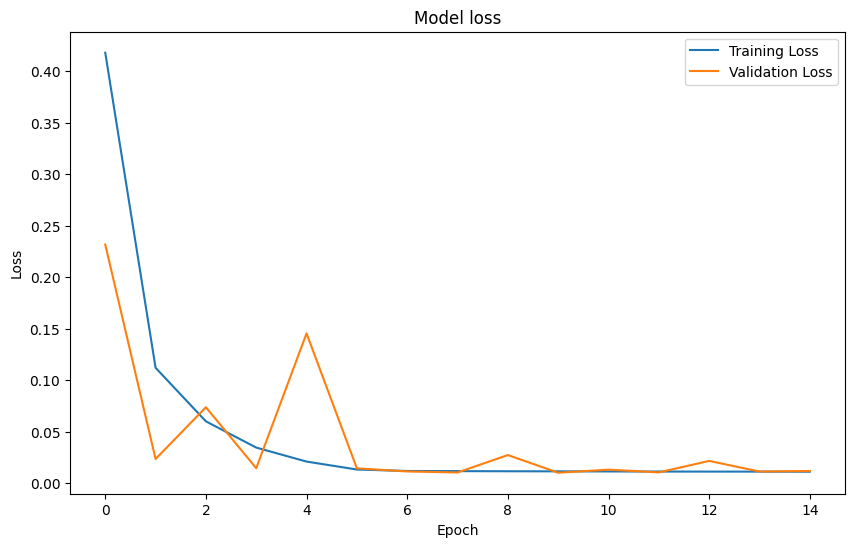

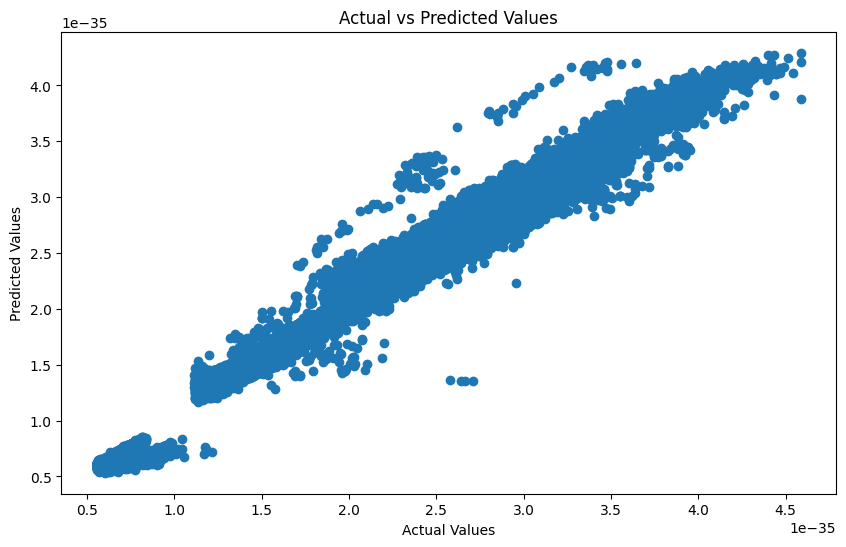

In [8]:

# Reshape the data for CNN
X = X.values.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets (1/5 of the data as a testing set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
progress_bar = ProgbarLogger(count_mode='steps', stateful_metrics=None)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping, progress_bar])

# Predict on test set
y_pred = model.predict(X_test)

# Calculate R^2 and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Calculate Median Relative Error
median_relative_error = median_absolute_error(y_test * ccs_std + ccs_mean, y_pred * ccs_std + ccs_mean) / np.median(y_test * ccs_std + ccs_mean)

print(f"R^2: {r2}")
print(f"MSE: {mse}")
print(f"Median Relative Error: {median_relative_error}")

# Plotting loss during training and validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test * ccs_std + ccs_mean, y_pred * ccs_std + ccs_mean)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Plot Model

13774/13774 [==============================] - 23s 2ms/step
Spearman's Correlation Coefficient: 0.9945474899573613


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Length', ylabel='Percent Error'>

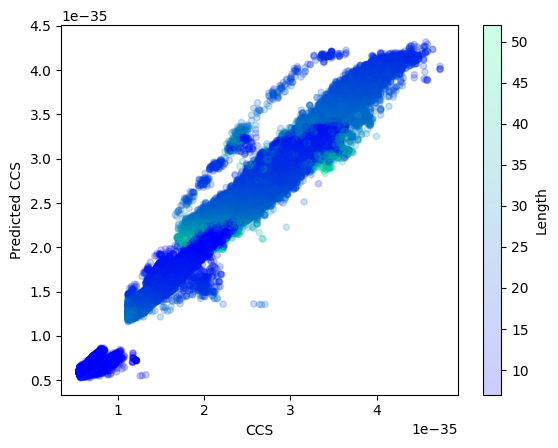

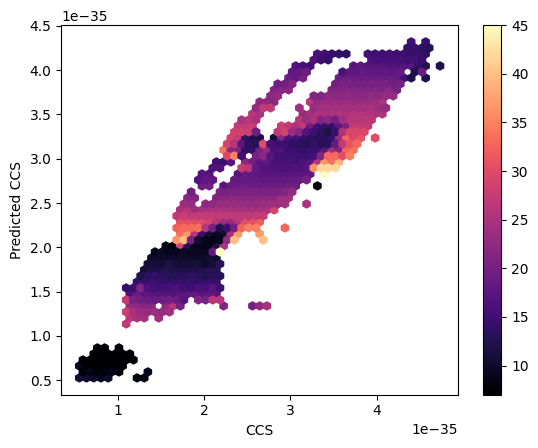

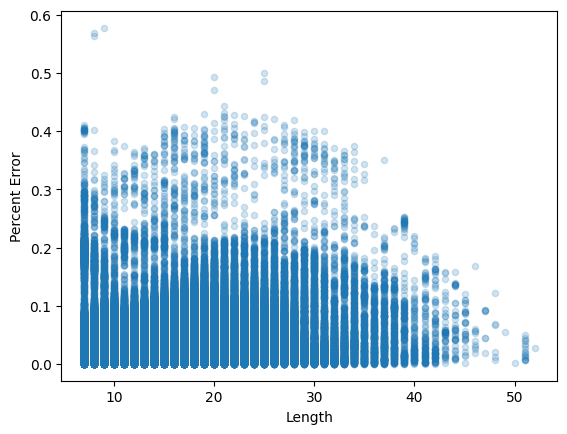

In [10]:
# Predict the CCS of the peptides in the data frame
mb_clean_frame['Predicted CCS'] = model.predict(X)

# Reverse the z-score transformation
mb_clean_frame['Predicted CCS'] = mb_clean_frame['Predicted CCS'] * ccs_std + ccs_mean

# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='CCS',
    y='Predicted CCS',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='CCS',
    y='Predicted CCS',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['CCS'].corr(mb_clean_frame['Predicted CCS'], method='spearman'))

# Create a scatter plot between the percent error and length
mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])
mb_clean_frame.plot.scatter(
    x='Length',
    y='Percent Error',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)


Save the model

In [ ]:
# Save the model
model.save('CCS_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle

# Save z-score parameters using pickle
with open('zscore_params_cnn_model.pkl', 'wb') as f:
    pickle.dump({'mean': ccs_mean, 'std': ccs_std}, f)


Using Model

In [ ]:
def predict_ccs(mass, charge, length):
    # Load the saved model
    model = tf.keras.models.load_model('CCS_cnn_model.h5')

    # Load the saved z-score parameters
    with open('zscore_params_cnn_model.pkl', 'rb') as f:
        params = pickle.load(f)
    ccs_mean = params['mean']
    ccs_std = params['std']

    # Create a numpy array with the input values
    new_data = np.array([[mass, charge, length]])

    # Reshape the data for CNN
    new_data = new_data.reshape(new_data.shape[0], new_data.shape[1], 1)

    # Predict the z-scored CCS value
    ccs_z_pred = model.predict(new_data)

    # Convert the z-scored CCS value back to original scale
    ccs_pred = ccs_z_pred * ccs_std + ccs_mean

    return ccs_pred[0][0]

# Test the function with some input values
mass = 1000  # replace with actual mass
charge = 2   # replace with actual charge
length = 10  # replace with actual length

predicted_ccs = predict_ccs(mass, charge, length)
print(f"Predicted CCS: {predicted_ccs}")


1/1 [==============================] - 0s 59ms/step
Predicted CCS: 2.0759578923421072e-35
